In [1]:
import csv
import gensim
import keras
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np
import os
import pandas as pd

from gensim.models import Word2Vec
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import sequence, text
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
RANDOM_SEED = 42
NB_CATEGORIES = 51

PADDING = 100
PRE_TRAINED_DIM = 300
REDUCED_DIM = 100

TRAINABLE = True # Training the embedding can lead to overfitting

dataDirPath = './challenge_data'
embeddingsDirPath = './../word_embeddings/'
xPath = os.path.join(dataDirPath, 'input_train.csv')
yPath = os.path.join(dataDirPath, 'output_train.csv')
xTestPath = os.path.join(dataDirPath, 'input_test.csv')
#embeddingPath = os.path.join(embeddingsDirPath, 'wiki.fr.vec')
#embeddingPath = os.path.join(embeddingsDirPath, 'retrained_fr.vec')
embeddingPath = os.path.join(embeddingsDirPath, 'retrained_questions.vec')

In [3]:
pretrainedEmbeddings = gensim.models.KeyedVectors.\
    load_word2vec_format(embeddingPath, binary=False)

In [4]:
x = pd.read_csv(xPath, delimiter=';', usecols=[1]).values.ravel()
xTest = pd.read_csv(xTestPath, delimiter=';', usecols=[1]).values.ravel()
y = pd.read_csv(yPath, delimiter=';', usecols=[1]).values.ravel()

In [5]:
correctionsDict = {}
correctionsPath = os.path.join(dataDirPath, 'corrections.csv')

with open(correctionsPath, 'r') as f:
    for key, val in csv.reader(f):
        correctionsDict[key] = val

def spellingCorrection(sentence, correctionsDict={}, verbose=False):
    correctedSentence = []
    nb_corrections = 0
    for word in sentence.split():
        if word in correctionsDict.keys():
            word = correctionsDict[word]
            nb_corrections += 1
        correctedSentence.append(word)
    if verbose:
        return ' '.join(correctedSentence), nb_corrections
    else:
        return ' '.join(correctedSentence)

nb_corr = 0
for i, s in enumerate(x):
    cor = spellingCorrection(s, correctionsDict, verbose = True)
    x[i] = cor[0]
    nb_corr += cor[1]

for i, s in enumerate(xTest):
    cor = spellingCorrection(s, correctionsDict, verbose = True)
    xTest[i] = cor[0]
    nb_corr += cor[1]
print(nb_corr)

7973


In [6]:
tokenizer = text.Tokenizer(
    num_words=1e5,
    filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'´’™©®«»",
    split=" "
)

tokenizer.fit_on_texts(np.concatenate((x, xTest)))
vocabulary = tokenizer.word_index.keys()
print('Vocabulary size: ', len(vocabulary))

Vocabulary size:  10175


In [7]:
x = tokenizer.texts_to_sequences(x)
x = sequence.pad_sequences(x, PADDING)
xTest = tokenizer.texts_to_sequences(xTest)
xTest = sequence.pad_sequences(xTest, PADDING)

y = to_categorical(y, num_classes=NB_CATEGORIES)

In [8]:
xTrain, xValid, yTrain, yValid = train_test_split(x, y, test_size=.2,
                                                  random_state=RANDOM_SEED)

In [9]:
MEDICAMENTS = []

with open(os.path.join(dataDirPath, 'medicList.txt')) as f:
    for line in f:
        MEDICAMENTS.append(line.lower().rstrip())

print('Liste de médicaments regroupant les libéllés ATC et les'
      'dénominations de spécialité, de taille: {}'.format(len(MEDICAMENTS)))
print('Sample of medicament names: ', MEDICAMENTS[:10])

Liste de médicaments regroupant les libéllés ATC et lesdénominations de spécialité, de taille: 8390
Sample of medicament names:  ['a 313 200  pour cent', 'a 313 50 000 u.i', 'abacavir', 'abacavir/lamivudine', 'abacavir/lamivudine pharma', 'abacavir/lamivudine pharos', 'abamipharm', 'abboticine', 'abelcet', 'abstral']


In [10]:
from unidecode import unidecode

In [11]:
embeddings = np.zeros((len(vocabulary) + 1 , PRE_TRAINED_DIM))
not_in_pretrained = []
detected_medic = []

for word, idx in tokenizer.word_index.items():
    if word not in pretrainedEmbeddings.vocab:
        unaccented = unidecode(word)
        if word in MEDICAMENTS:
            vec = pretrainedEmbeddings['médicament']
            detected_medic.append(word)
        else:
            vec = np.zeros(PRE_TRAINED_DIM)
            not_in_pretrained.append(word)
    else:
        vec = pretrainedEmbeddings[word]

    # word_to_index is 1-based! the 0-th row, used for padding, stays at zero
    embeddings[idx,] = vec

In [12]:
print('---------- Embedding Created ----------')
print('Number of words in corpus that do not appear in '
      'pretrained Fasttext: ', len(not_in_pretrained))
print('size of the embedding: {}'.format(embeddings.shape))

---------- Embedding Created ----------
Number of words in corpus that do not appear in pretrained Fasttext:  1164
size of the embedding: (10176, 300)


In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=REDUCED_DIM)
reducedEmbeddings = pca.fit_transform(embeddings)

In [14]:
class CustomModel():
    '''Generic workflow class.'''

    def __init__(self, **kwargs):
        self.verbose = kwargs.get('verbose', False)

        self.nbCategories = kwargs['nbCategories']
        self.paddingLength = PADDING
        self.trainable = kwargs.get('trainable', False)

    def train(self, x, y, epochs= 10, batch_size=32, validation_data=None, callback=False):
        if callback == True:
            filepath= '../models_checkpoints/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
            checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                                         verbose=1, save_best_only=True, mode='max')
            callbacks_list = [checkpoint]

            return self.model.fit(x, y, shuffle='batch', epochs=epochs,
                                  verbose=1 if self.verbose else 0,
                                  batch_size=batch_size, validation_data=validation_data,
                                  callbacks=callbacks_list)
        else:
            return self.model.fit(x, y, shuffle='batch', epochs=epochs,
                                  verbose=1 if self.verbose else 0,
                                  batch_size=batch_size, validation_data=validation_data)

    def evaluate(self, x, y):
        return self.model.evaluate(x, y)

    def predict(self, x):
        return self.model.predict(x)

In [15]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import (Input, Conv2D, Dense, Dropout,
                          MaxPooling2D, Flatten, Concatenate, Reshape)


class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def buildCNN2D(self, embedding, drop_rates=[.3, .3] , nb_filters=128, filter_size=[3,4,5],
                   padding=PADDING):
        self.embedding = embedding

        my_input = Input(shape=(self.paddingLength, ), name= 'input')

        embedding = Embedding(input_dim=self.embedding.shape[0],
                               output_dim=self.embedding.shape[1],
                               weights=[self.embedding],
                               input_length=self.paddingLength,
                               trainable=self.trainable,
                               name='embedding')(my_input)
        embedding = Reshape((padding, self.embedding.shape[1], 1))(embedding)
        embedding_dropped = Dropout(drop_rates[0], name='drop0')(embedding)
        
        # one concatenates 3 filter sizes
        conv0 = Conv2D(nb_filters, (filter_size[0], self.embedding.shape[1]),
                       activation='relu', name='conv0', padding='valid')(embedding_dropped)
        pooled0 = MaxPooling2D(pool_size=(padding - filter_size[0] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool0')(conv0)
        
        conv1 = Conv2D(nb_filters, (filter_size[1], self.embedding.shape[1]),
                       activation='relu', name='conv1', padding='valid')(embedding_dropped)
        pooled1 = MaxPooling2D(pool_size = (padding - filter_size[1] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool1')(conv1)
        
        conv2 = Conv2D(nb_filters, (filter_size[2], self.embedding.shape[1]),
                       activation='relu', name='conv2', padding='valid')(embedding_dropped)
        pooled2 = MaxPooling2D(pool_size = (padding - filter_size[2] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool2')(conv2)
        
        concatenated = Concatenate(axis=1)([pooled0, pooled1, pooled2])
        flattened = keras.layers.Flatten()(concatenated)
        dropped1 = Dropout(drop_rates[1], name='drop1')(flattened)  
        prob = Dense(self.nbCategories, activation='softmax', name='dense2')(dropped1)

        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

In [16]:
DROP_RATES = [.4, .4]
NB_FILTERS = 512
FILTER_SIZE = [2,3,5]

trainingHistory = {}

model = CustomModel(verbose=True, nbCategories=NB_CATEGORIES, trainable=TRAINABLE)
# model.buildCNN1D(reducedEmbeddings, drop_rates=DROP_RATES, nb_filters=NB_FILTERS,
#                  filter_size=FILTER_SIZE)
model.buildCNN2D(reducedEmbeddings, drop_rates=DROP_RATES, nb_filters=NB_FILTERS)
model.model.summary()
print('Total number of model parameters:', model.model.count_params())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 100)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     1017600     input[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 100, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
drop0 (Dropout)                 (None, 100, 100, 1)  0           reshape_1[0][0]                  
__________________________________________________________________________________________________
conv0 (Con

In [17]:
model.model.load_weights('../models_checkpoints/weights-improvement-07-0.72.hdf5')

In [18]:
loss = model.evaluate(xValid, yValid)

prediction = model.predict(xValid)
predictionCategories = np.argmax(prediction, axis=1)
yValidCategories = np.argmax(yValid, axis=1)
accuracy = 100 * sum([predictionCategories[i] == yValidCategories[i]
                      for i in range(len(yValidCategories))]) / len(yValidCategories)

print('Accuracy: {:.2f} %\nLoss: {}'.format(accuracy, str(loss)))

1606/1606 [==============================] - 7s 4ms/step
Accuracy: 72.35 %
Loss: [1.1744357674089196, 0.72353673730959478]


In [19]:
import collections

In [20]:
yPosition = np.arange(2*NB_CATEGORIES)

c = collections.Counter(yValidCategories)
od = collections.OrderedDict(sorted(c.items(), key=lambda x: x[0]))
cp = collections.Counter(predictionCategories)
odp = collections.OrderedDict(sorted(cp.items(), key=lambda x: x[0]))

correctResults = predictionCategories[predictionCategories == yValidCategories]
cc = collections.Counter(correctResults)
odc = collections.OrderedDict(sorted(cc.items(), key=lambda x: x[0]))

In [21]:
pod = np.zeros(2*NB_CATEGORIES)
for key in od:
    pod[2*key] = od[key]

podp = np.zeros(2*NB_CATEGORIES)
for key in odp:
    podp[2*key+1] = odp[key]

podc = np.zeros(2*NB_CATEGORIES)
for key in odc:
    podc[2*key+1] = odc[key]

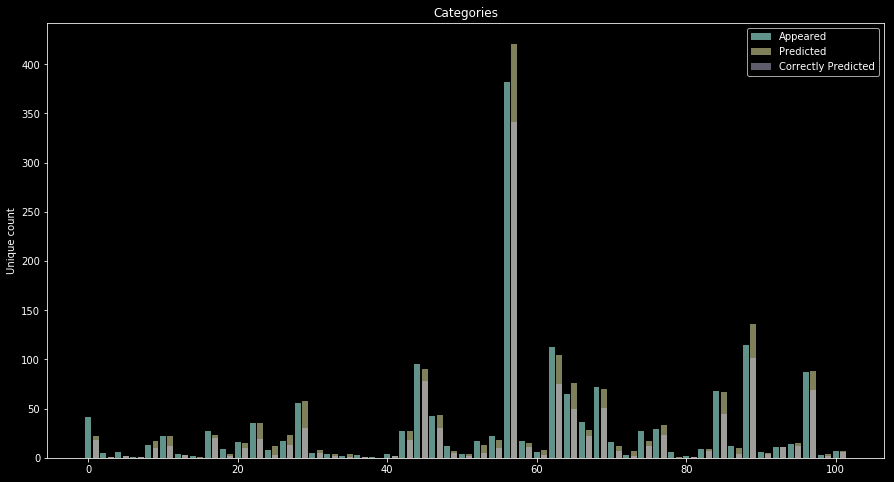

In [22]:
plt.figure(figsize=(15,8))
#plt.yscale('log')

plt.bar(yPosition, pod, alpha=0.7, label='Appeared')
plt.bar(yPosition, podp, alpha=0.5, label='Predicted')
plt.bar(yPosition, podc, alpha=0.5, label='Correctly Predicted')

plt.ylabel('Unique count')
plt.title('Categories')
plt.legend()
 
plt.show()

## Exploration of what went wrong

In [23]:
W2IX = {}
for k, v in tokenizer.word_index.items():
    W2IX[v] = k
def seq2sent(s, w2ix = W2IX):
    sent = []
    for w in s:
        if w != 0:
            sent.append(w2ix[w])
    return ' '.join(sent)

In [24]:
w_pred = {}
t_pred = {}
for c in np.arange(NB_CATEGORIES):
    w_pred[c] = []
    t_pred[c] = []

for q, t_lab, pred_lab in zip(xValid, yValidCategories, predictionCategories):
    q = seq2sent(q)
    if pred_lab == t_lab:
        t_pred[t_lab].append(tuple((pred_lab, q)))
    else:
        w_pred[t_lab].append(tuple((pred_lab, q)))

In [25]:
assignation_matrix = np.zeros((NB_CATEGORIES, NB_CATEGORIES))
for c in np.arange(NB_CATEGORIES):
    for e in w_pred[c]:
        assignation_matrix[c,e[0]] += 1

## Explore wrong predictions 

In [28]:
ix = 0
print(t_pred[ix][:5])
print('-----------wrong prediction------------')
w_pred[0]

[(0, 'quelle alternative à la rupture de havrix'), (0, 'quelle alternative au plavix'), (0, 'compose de depakote 100 mg je suis bipolaire de 3 xanax de 0 5 auparavent 4 j ai beaucoup de mal a diminuer et tercian neuroleptique que j aimerais arrêter donc me sevrer car il me shoote trop et c est pas compatible avec le travail de plus il me fait prendre bip de poids le tableau je suis insomniaque depuis 15 ans rien a faire alors je prends chaque soir un peu de mélatonine 5mg et ca m aide bcp est ce une bonne idée de remplacer le tercian qui m est donne pour dormir par de la melatonine'), (0, 'puis je prendre lectil à la place de serc ou bétaserc'), (0, 'quelle alternative au méningite en cas de rupture')]
-----------wrong prediction------------


[(44,
  'le cérat de alien contre indiqué chez les enfants de moins de 3 ans quelle alternative'),
 (5, 'for et priopix la mémé chose ou pas'),
 (10, 'changement diane 35'),
 (42, '2 engerix 10 1 engerix 20'),
 (5,
  'je suis sous triella est ce que quelqu un s y connaîtrait dans le domaine et me conseillerai une pilule équivalente'),
 (44,
  'bonjour j aimerais arrêter de prendre du bromazepam anxiolitique pour m endormir car je souhaiterais avoir un enfant quel médicament puis je prendre en substitution sans risque pour le bébé j ai essayé plusieurs fois d arrêter sans succès j attends avec impatience une réponse d avance merci'),
 (38,
  'je prend du seresta 3 fois par jour mais je me réveille quand j arrive à dormir toujours en pleine crise d angoisse ne serait il pas plus judicieux de prendre un lexomil le soir qui a une durée de vie plus longue'),
 (11, 'allergique au flacon que faire'),
 (32,
  'je souffre d une hyper pilosité et mon dermatologue m a prescrit de l androcur mais 